# Week 07 Lecture: Molecular Dynamics Concepts 2

- temperature
- forcefields
- non-bonded interactions
- periodic boundaries

Links: 
    
[Kahn-Academy Maxwell-Boltzmann](https://www.khanacademy.org/science/physics/thermodynamics/temp-kinetic-theory-ideal-gas-law/a/what-is-the-maxwell-boltzmann-distribution)  
[MolSSI MMTools](https://education.molssi.org/mm-tools/)  


## A molecular definition of temperature

**What is temperature?** What really makes a cup of cold water different from a cup of hot water?

 <img src="https://upload.wikimedia.org/wikipedia/commons/1/17/Water_and_ice.jpg" width="200"></img><img src="https://cdn.pixabay.com/photo/2021/02/04/20/04/tea-5982485_1280.jpg" width="200"></img> 

## Temperature is a speedometer

**The hotter water molecules are moving faster.**  The relationship between the temperature and the mean squared velocity of the particles ($\langle{v^2}\rangle$) is:

$$T = \frac{m \langle{v^2}\rangle}{n k_B}$$

where $n$ is the number of spatial dimensions, $m$ is the particle mass, and $k_B$ is Boltzmann's constant. 

$T$ here is in Kelvin, showing that at absolute zero (-273.15 C), the average squared velocity is zero and all particles are perfectly stationary.

## Maxwell-Boltzmann distribution

The distribution of molecular speeds is given by:

$$P(|v|) = \left(\frac{m}{2\pi k_B T}\right)^{3/2} v^2 e^{-\frac{m v^2}{2k_b T}}$$

where $P(|v|)$ is the probability of a particular speed (or velocity magnitude, $|v|$).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

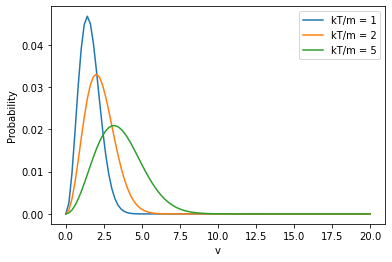

In [2]:
def mb_prob(v,kt_over_m):
    return (1/(2*np.pi*kt_over_m))**(1.5)*v**2*np.exp(-np.square(v)/(2*kt_over_m)) 

v = np.linspace(0,20,100)
for kt_over_m in [1,2,5]:
    plt.plot(v,mb_prob(v,kt_over_m),label=f'kT/m = {kt_over_m}')
plt.xlabel("v")
plt.ylabel("Probability")
plt.legend()

A particular component of the velocity (say, $v_x$) is distributed according to:

$$P(v_x) = \left(\frac{m}{2\pi k_B T}\right)^{1/2} e^{-\frac{m v_x^2}{2k_b T}}$$

Notice the difference in the exponent (1/2 vs 3/2) and that the $v^2$ term is missing.

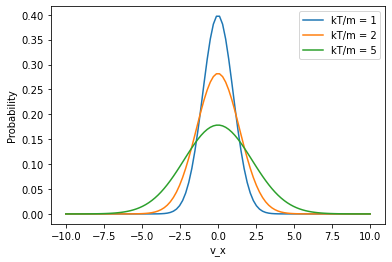

In [3]:
def mb_prob_x(vx,kt_over_m):
    return (1/(2*np.pi*kt_over_m))**(0.5)*np.exp(-np.square(vx)/(2*kt_over_m)) 

vx = np.linspace(-10,10,100)
for kt_over_m in [1,2,5]:
    plt.plot(vx,mb_prob_x(vx,kt_over_m),label=f'kT/m = {kt_over_m}')
plt.xlabel("v_x")
plt.ylabel("Probability")
plt.legend()

## Initializing particle velocities

How do we initialize particle velocities in a way that is random, but still consistent with the MB distribution?

**Use the cumulative distribution function for $P(v_x)$:**

$$CDF(V_x) = \frac{\int_{-\infty}^{V_x} P(v_x) dv_x}{\int_{-\infty}^{\infty} P(v_x) dv_x}$$

This is equal to:

$$CDF(V_x) = \frac{1}{2} \left(\text{erf}\left(\sqrt{\frac{m}{2k_b T}}V_x\right) + 1 \right)$$

where $\text{erf}$ is the "error function".

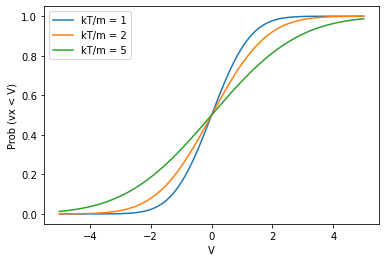

In [4]:
from scipy.special import erf

def cdf(vx,kt_over_m):
    return 0.5*(erf(np.sqrt(1/(2*kt_over_m))*vx) + 1)

vx = np.linspace(-5,5,100)
for kt_over_m in [1,2,5]:
    plt.plot(vx,cdf(vx,kt_over_m),label=f'kT/m = {kt_over_m}')
plt.xlabel("V")
plt.ylabel("Prob (vx < V)")
plt.legend()

**How does this help us initialize our velocities?**

If we generate a series of random numbers in the range $[0,1]$, we can map these to a series of velocity values using the CDF!

$$R = \frac{1}{2} \left(\text{erf}\left(\sqrt{\frac{m}{2k_b T}}V_{gen}\right) + 1 \right)$$

but first we need to solve this equation for $V_{gen}$:

$$V_{gen} = \sqrt{\frac{2k_b T}{m}}\text{erfinv}\left(2R - 1\right)$$

where $\text{erfinv}$ is -- you guessed it -- the "inverse error function".

In [5]:
from scipy.special import erfinv
import numpy as np

def init_vel(kt_over_m, shape):
        R = np.random.random(shape)   # generates a set of numbers uniformly in [0,1]
        return np.sqrt(2*kt_over_m)*erfinv(2*R-1)

**Let's check a distribution of $v_x$ values:**

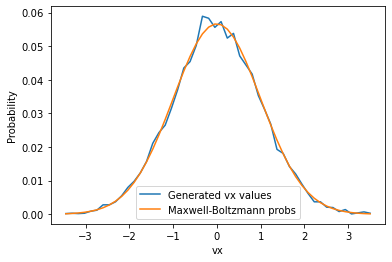

In [6]:
counts, bins = np.histogram(init_vel(1,(10000)), bins=50)
cbins = 0.5*(bins[1:] + bins[:-1])  # get bin midpoints
probs = counts / counts.sum()       # normalize counts -> probabilities

mb_probs = mb_prob_x(cbins,1)
mb_probs /= mb_probs.sum()          # normalize by sum for proper comparison

plt.plot(cbins, probs, label='Generated vx values')
plt.plot(cbins, mb_probs, label='Maxwell-Boltzmann probs')
plt.xlabel('vx')
plt.ylabel('Probability')
plt.legend()

## Thermostats

In this course we will only be using **Langevin dynamics** which acts as its own thermostat.  But here are some others:

| Algorithm | Description |
|:---|:---|
| **Nosé-Hoover** | adds extra degree of freedom ($s$) that scales all velocities; $s$ has a mass and moves to keep simulation at desired $T$ |
| **Andersen** | simulates "collisions" of randomly chosen particles and resamples their velocity according to Maxwell-Boltzmann |
| **Berendsen** | rescales all velocities at each step towards the target temperature; can result in the [Flying Ice Cube Effect](https://en.wikipedia.org/wiki/Flying_ice_cube) |

**"Friends don't let friends use Berendsen."** - @jchodera [tweet](https://twitter.com/jchodera/status/1182035924957515777)

## Force fields

Last week we used a simple **potential energy function** for our one-particle simulations.  For biomolecular systems these need to contain all of the information about each atom (its charge, radius, etc) and how it interacts with other atoms in the system.  

The interactions can be neatly separated into **bonded** and **non-bonded** interactions:

$$U({\bf x}) = U_{\text{bonded}}({\bf x}) + U_{\text{non-bonded}}({\bf x})$$

**Reminder:** the variable ${\bf x}$ holds all of the positions of all the atoms in the system.  Today let's consider ${\bf x}$ to be a 2D tensor (or, a 2D array) of size $(N,3)$.

The **bonded** energy function describes interactions that are due to covalent bonds:

$$U_{\text{bonded}}({\bf x}) = U_{\text{bond}} + U_{\text{angle}} + U_{\text{torsion}} + U_{\text{improper}}$$

<img src="https://www.researchgate.net/profile/Emal-Alekozai/publication/280664616/figure/fig16/AS:648243079831554@1531564602615/Schematic-illustration-of-the-bonded-terms-in-the-CHARMM-force-field-adapted-from.png" height="200"></img> 

The **non-bonded** energy function is composed of **electrostatic** and **Lennard-Jones** interactions:

$$U_{\text{non-bonded}}({\bf x}) = U_{\text{elec}} + U_{\text{LJ}}$$

$U_{\text{elec}}$ is the interaction between charged groups from [Coulomb's Law](https://en.wikipedia.org/wiki/Coulomb%27s_law):

$$U_{\text{elec}} = k_e \sum_{i \ne j} \frac{q_i q_j}{r_{ij}}$$

where $k_e$ is Coulomb's constant, $q_a$ is the "partial charge" on atom $a$, and $r_{ij}$ is the distance between atoms $i$ and $j$.

$U_{\text{LJ}}$ is the interaction between particles that doesn't account for their net charge.  It does a couple of things:

- **prevents atomic electron clouds from overlapping in space** (which is not allowed by the [Pauli Exclusion principle](https://en.wikipedia.org/wiki/Pauli_exclusion_principle))
- **allows for favorable "induced dipole" interactions** (also referred to as "van der Waals" interactions, "London" forces, or "dispersion" forces)

<img src="https://o.quizlet.com/Wpeenr2psYttiQfEqyP3Iw_b.png" height="200"></img> 


The commonly used equation to describe these forces is the ["Lennard-Jones" potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential):

$$U_{\text{LJ}} = \sum_{i \ne j} 4\epsilon_{ij} \left[ \left( \frac{\sigma_{ij}}{r_{ij}}\right)^{12} - \left( \frac{\sigma_{ij}}{r_{ij}} \right)^6\right]$$

where $\epsilon_{ij} = \sqrt{\epsilon_i \epsilon_j}$, and $\sigma_{ij} = \frac{1}{2}(\sigma_i + \sigma_j)$.

$\sigma_a$ is the van der Waals radius of atom $a$ and $\epsilon$ is the depth of its van der Waals energy well.

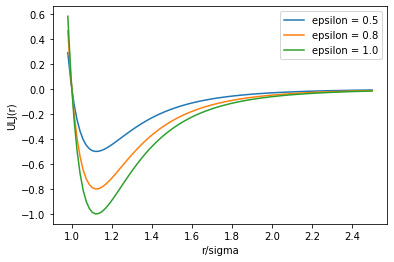

In [7]:
def ULJ(r_over_sigma, epsilon):
    
    sigma_over_r = 1/r_over_sigma
    sor6 = sigma_over_r**6
    sor12 = sor6**2
    
    return 4*epsilon*(sor12-sor6)

r_o_s = np.linspace(0.98,2.5,100)
plt.plot(r_o_s, ULJ(r_o_s, 0.5), label='epsilon = 0.5')
plt.plot(r_o_s, ULJ(r_o_s, 0.8), label='epsilon = 0.8')
plt.plot(r_o_s, ULJ(r_o_s, 1.0), label='epsilon = 1.0')
plt.xlabel("r/sigma")
plt.ylabel("ULJ(r)")
plt.legend()

## Periodic boundaries

<img src="https://upload.wikimedia.org/wikipedia/commons/e/eb/Periodic_Boundary_Conditions_in_2D.png" width="500"/>

When conducting molecular simulations we can only afford to include so many particles.  A common way to minimize the effects of a finite system size is to include **periodic boundaries**.  

This essentially assumes that the simulation cell is surrounded in all directions by other identical simulation cells.

The implementation of periodic boundaries seems simple enough:  
- if you exit through the left side, you enter through the right
- if you exit through the top, you enter through the bottom
- etc.

**But periodic boundaries can be tricky and are probably the cause of most errors and bugs in molecular dynamics simulations.**


## "Wrapping" coordinates

To apply those rules above and make sure particles do not leave the simulation box, you need to periodically "wrap" the coordinates back into the box.

Below is trajectory that leaves a simulation box, defined in two dimensions as $x \in [-0.5,0.5]$, $y \in [-0.5,0.5]$:

(-1.0, 1.0)

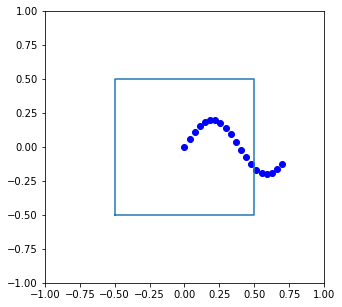

In [8]:
# an imaginary trajectory
traj = np.zeros((20,2))
traj[:,0] = np.linspace(0,0.7,20)
traj[:,1] = 0.2*np.sin(8*traj[:,0])

# used for visualizing the box
box_x = [-0.5,0.5,0.5,-0.5,-0.5]
box_y = [-0.5,-0.5,0.5,0.5,-0.5]

plt.figure(figsize=[5,5])
plt.plot(traj[:,0],traj[:,1],'bo')
plt.plot(box_x,box_y)
plt.xlim([-1,1])
plt.ylim([-1,1])

Here is a function that applies boundary conditions to a given trajectory frame and returns the "wrapped" positions back inside the box:

In [9]:
def apply_pbc(positions, box_size):
    # positions and box size are both arrays with
    # a dimensionality equal to the number of spatial dimensions
    # i.e. if we are in 2D space, each array has two elements
    
    half_box_size = box_size * 0.5
    pbc_wrap_positions = np.zeros_like(positions)

    old_positions = positions

    # this while loop allows adjustments to be made until 
    # the positions of the particles stops changing
    while np.any(pbc_wrap_positions != old_positions):
        #
        # Note on np.where syntax:
        # np.where(CONDITION, value_if_true, value_if_false)
        #
        pbc_wrap_positions = np.where(positions > half_box_size,
                                      positions - box_size,
                                      positions)

        pbc_wrap_positions = np.where(positions <= -half_box_size,
                                      positions + box_size,
                                      pbc_wrap_positions)
        old_positions = pbc_wrap_positions
    return pbc_wrap_positions

Let's try this out by applying it to all of the frames in our trajectory:

(-1.0, 1.0)

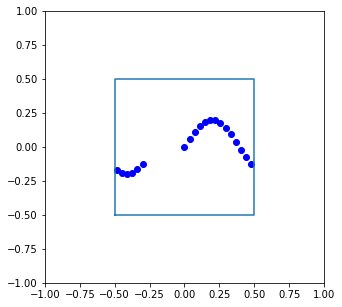

In [10]:
new_frames = []
box_size = np.array([1,1])
for frame in traj:
    new_frames.append(apply_pbc(frame,box_size))

new_traj = np.array(new_frames)
plt.figure(figsize=[5,5])
plt.plot(new_traj[:,0],new_traj[:,1],'bo')
plt.plot(box_x,box_y)
plt.xlim([-1,1])
plt.ylim([-1,1])

**Note that we can use the same function with 3D data as well:**

In [11]:
unwrapped_trajectory = np.random.random(size=(100,10,3))*10  # nframes, nparticles, ndim

print("Max x coordinate:",unwrapped_trajectory[:,:,0].max())
print("Max y coordinate:",unwrapped_trajectory[:,:,1].max())
print("Max z coordinate:",unwrapped_trajectory[:,:,2].max())

Max x coordinate: 9.997272451544207
Max y coordinate: 9.995211595558018
Max z coordinate: 9.997304830041116


In [12]:
box_size = np.array([5,5,5])
wrapped_trajectory = apply_pbc(unwrapped_trajectory,box_size)

print("Max x coordinate (after wrapping):",wrapped_trajectory[:,:,0].max())
print("Max y coordinate (after wrapping):",wrapped_trajectory[:,:,1].max())
print("Max z coordinate (after wrapping):",wrapped_trajectory[:,:,2].max())

Max x coordinate (after wrapping): 4.997272451544207
Max y coordinate (after wrapping): 4.995211595558018
Max z coordinate (after wrapping): 4.9973048300411165


## Displacement vectors through periodic boundaries

Wrapping is important, but it is also important that inter-particle forces are computed properly through periodic boundaries.  In other words, **even though the positions of two particles are far apart, their "images" in adjacent cells could be close together.**  If these interactions aren't taken into account, particles could experience discontinuities in their forces as they are wrapped through the periodic boundary.  **For instance, a particle would know that it is sitting almost on top of another particle until it crosses the boundary, at which point it suddenly experiences an ultra-high repulsive force, and then your system explodes!**

To avoid this catastrophic scenario, we will make sure to compute forces using the closest possible displacement vector.

Consider two particles $i$ and $j$:

![periodicity schematic](https://github.com/ADicksonLab/ml4md-jb/blob/main/figures/periodic-01.png?raw=true)

The difference in their $x$ coordinates can be calculated three ways:

-  directly ($x_j - x_i$)
-  using the "right hand image" ($x_j - (x_i + L_x)$)
-  using the "left hand image" ($x_j - (x_i - L_x)$)

where $L_x$ is the length of the box in the $x$ direction.

**Clearly if we want $i$ and $j$ to "feel" each other across the periodic boundary, we need to use the difference with the smallest magnitude when we are calculating the forces.**

The following function determines the shortest displacement vector between two atoms, **even considering images that differ by more than one box length**.

In [13]:
def shortest_disp_vector(posA, posB, box_size):

    r = posA - posB   # has one element for each spatial dimension

    # loop over spatial dimensions
    for i in range(len(posA)):
        
        # if difference is greater than half the box length, adjust
        if r[i] < -0.5*box_size[i]:
            
            # determine number of adjustments needed
            n = int((r[i] + 0.5*box_size[i])/box_size[i]) + 1  

            # make them
            r[i] += n*box_size[i]
        elif r[i] > 0.5*box_size[i]: # same thing in the negative direction
            n = int((r[i] - 0.5*box_size[i])/box_size[i]) + 1
            r[i] -= n*box_size[i]

    return r

**Now let's test this out:**

In [15]:
positions = np.array([[0.01,0.52,0.55],
                      [0.90,0.51,0.2]])  # two particles in 3D space
box_size = [1,1,1]

# compute direct displacement vector
direct_disp_vec = positions[0] - positions[1]
print("Direct displacement vector:",direct_disp_vec,"has magnitude:",np.sqrt(np.sum(np.square(direct_disp_vec))))

# compute displacement vector through the boundaries
closest_disp_vec = shortest_disp_vector(positions[0],positions[1],box_size)
print("Shortest displacement vector:",closest_disp_vec,"has magnitude:",np.sqrt(np.sum(np.square(closest_disp_vec))))

Direct displacement vector: [-0.89  0.01  0.35] has magnitude: 0.9563994981178107
Shortest displacement vector: [0.11 0.01 0.35] has magnitude: 0.3670149860700514


**In this week's lab** we will be using a periodic box to simulate a set of Liquid Argon atoms.